## Rossman Store Sales Analysis and Forecasting

Rossman Store Sales dataset is available on [Kaggle: Rossman Store Sales](https://www.kaggle.com/c/rossmann-store-sales/data). The competition goal is to find the best sales forecast for a store.

### Exploratory Analysis 

First load the data and explore what the variables are.

In [18]:
# inline figures
%matplotlib inline

# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import mpld3

# for responsive plots
mpld3.enable_notebook()

# ignore all warnings
warnings.filterwarnings('ignore')

# load data as time-series while reading from csv file
train = pd.read_csv('../data/rossmann_store_sales/train.csv', index_col='Date')
# sort 
train.sort(ascending=True, inplace=True)
train.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1
2013-01-01,375,2,0,0,0,0,a,1
2013-01-01,374,2,0,0,0,0,a,1
2013-01-01,373,2,0,0,0,0,a,1
2013-01-01,372,2,0,0,0,0,a,1


It appears the dates are not sorted, lets sort the dates.

In [2]:
train.sort(ascending=True, inplace=True)
train.index

Index(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
       '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
       ...
       '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
       '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31'],
      dtype='object', name='Date', length=1017209)

In [3]:
train.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1
2013-01-01,375,2,0,0,0,0,a,1
2013-01-01,374,2,0,0,0,0,a,1
2013-01-01,373,2,0,0,0,0,a,1
2013-01-01,372,2,0,0,0,0,a,1


Every timestamp or date has multiple entries as the data arises from many stores for each date. Lets consider sales and customer data for each date, therefore we need to calculate the "average" sales and customers of all stores for each date. "Average" is in quotes because it could be understood as either mean or median. The benchmark for the competition predicts sales for a given store as a median of sales from all stores on the same day of the week. Therefore, I will use median as my "average". 

In [4]:
# group-by Date for Sales and Customers
train_sales = train.groupby([train.index])['Sales'].median()
train_sales.index = pd.to_datetime(train_sales.index) # change index to datetime
train_sales.head(10)

Date
2013-01-01       0
2013-01-02    5737
2013-01-03    5292
2013-01-04    5623
2013-01-05    5018
2013-01-06       0
2013-01-07    9277
2013-01-08    7479
2013-01-09    6681
2013-01-10    6680
Name: Sales, dtype: int64

Lets visualise the data by plotting it.

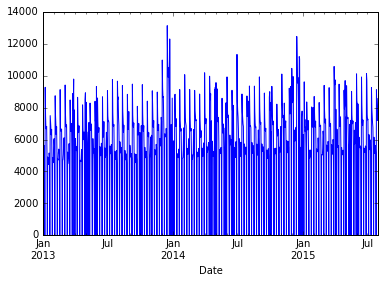

In [5]:
# plot
train_sales.plot()

Time series modelling can be performed on stationary timeseries. From this plot, sales timeseries does not appear to have a increasing mean or variance. Therefore, this could be a stationary signal already. Lets do a Dickey-Fuller test.

In [6]:
# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

df = adfuller(train_sales)
print('Test statistic: {}'.format(df[0]))
print('pvalue: {}'.format(df[1]))
print('#lags used: {}'.format(df[2]))
print('#observations used: {}'.format(df[3]))
for key,value in df[4].items():
    print('Critical {}: {}'.format(key, value))

Test statistic: -5.506323779351345
pvalue: 2.0180664961628965e-06
#lags used: 21
#observations used: 920
Critical 10%: -2.5684454926748583
Critical 5%: -2.864686684217556
Critical 1%: -3.4374778690219956


Test-statistic is very less compared to all Critical values and p-value is almost close to zero. The timeseries is stationary and does not have a Unit root. Sales data usually is considered to have seasonal variations. However, lets perform a seasonal decomposition to segregate trend, seasonal and residual timeseries and then estimate autocorelation in the residual series.

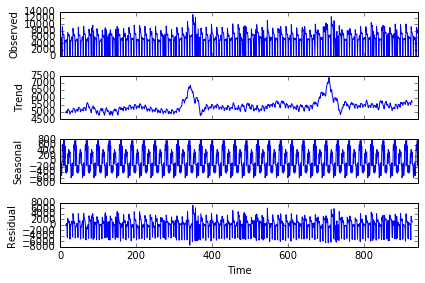

In [8]:
# seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train_sales.values, freq=30)
fig = decomp.plot()
fig.show()

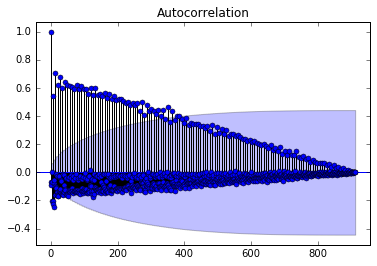

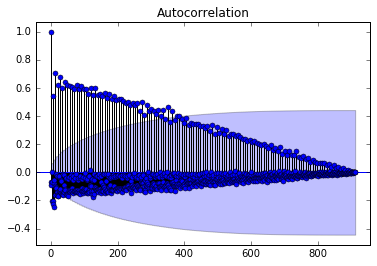

In [16]:
# 
import statsmodels.graphics.tsaplots as tsaplots

# convert residual to timeseries
dates = pd.date_range(train_sales.index[0], train_sales.index[-1], freq='D')
residuals = pd.Series(decomp.resid, index=dates)
tsaplots.plot_acf(residuals.dropna())

The residuals appear to have too much autocorrelation, there is something wrong with this. Let me plot autocorrelation and partial autocorrelation of the original timeseries.

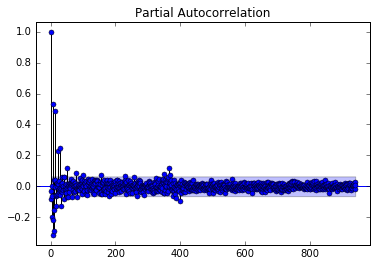

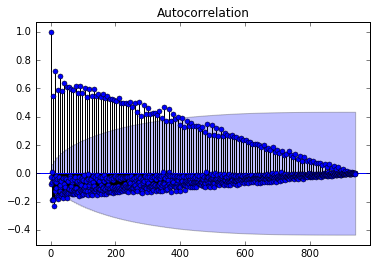

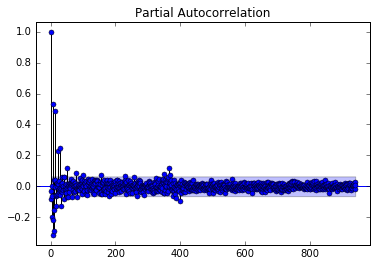

In [19]:
tsaplots.plot_acf(train_sales.dropna())
tsaplots.plot_pacf(train_sales.dropna())


In [75]:
# seasonal and trend adjusted timeseries
decomp.observed

array([    0,  5737,  5292,  5623,  5018,     0,  9277,  7479,  6681,
        6680,  6825,  5052,     0,  4903,  4595,  4440,  4558,  5154,
        4970,     0,  7501,  7064,  6604,  6303,  6636,  4812,     0,
        4868,  4547,  4918,  5931,  6054,  5625,     0,  8746,  7488,
        6826,  6312,  6809,  5161,     0,  4797,  4709,  5169,  5401,
        5251,  5100,     0,  9131,  6708,  6548,  6516,  6660,  4693,
           0,  4683,  4745,  5073,  5954,  6108,  5590,     0,  9420,
        7572,  6848,  6788,  6923,  5053,     0,  5211,  4494,  4845,
        5128,  5739,  5286,     0,  8482,  7268,  6506,  6652,  6999,
        5215,     0,  8878,  7851,  8185,  9795,     0,  7855,     0,
           0,  6068,  5312,  5448,  5570,  5160,     0,  8648,  7107,
        6448,  6433,  6862,  4951,     0,  4689,  4694,  4616,  4797,
        5371,  4910,     0,  8174,  6789,  6028,  5990,  6476,  5244,
           0,  8511,  8934,     0,  8338,  7511,  5409,     0,  5723,
        5617,  6480,

Lets perform the Dickey-Fuller test on the adjusted timeseries.

In [61]:
df = adfuller(sales_adjusted.dropna())
print('Test statistic: {}'.format(df[0]))
print('pvalue: {}'.format(df[1]))
print('#lags used: {}'.format(df[2]))
print('#observations used: {}'.format(df[3]))
for key,value in df[4].items():
    print('Critical {}: {}'.format(key, value))

Test statistic: -11.134720258130908
pvalue: 3.2166216746558343e-20
#lags used: 21
#observations used: 890
Critical 5%: -2.8647929301713977
Critical 1%: -3.43771883253448
Critical 10%: -2.568502085595253


Test-statistic is very less compared to Critical values. Compared to unadjusted timeseries, adjusted timeseries is a better representative of a stationary timeseries. 

Lets explore autocorelation and partial corelation charts for dependencies. 

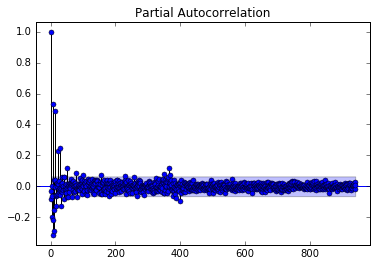

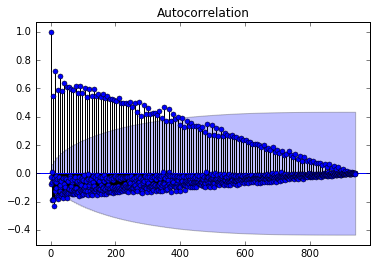

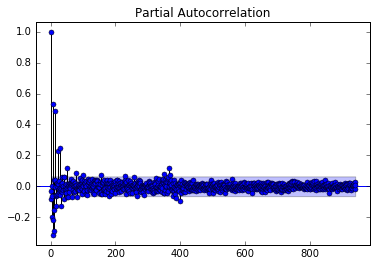

In [76]:
# 
import statsmodels.graphics.tsaplots as tsaplots

tsaplots.plot_acf(train_sales)
tsaplots.plot_pacf(train_sales)

[Duke University](http://people.duke.edu/~rnau/411arim3.htm) provides a good reference for understanding how to interpret ACF and PACF plots. From Autocorelation plot, it appears that the value at lag=1 is negative therefore this model has a MA-signature. From the Partial Autocorelation plot, it appears that after lag=14 the influence of remaining lags are minimal. Hence, an AutoRegressive(AR) term with Lag=14 might help us in modelling this timeseries.

I will now attempt to model this timeseries using ARMA models.